# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK** 

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


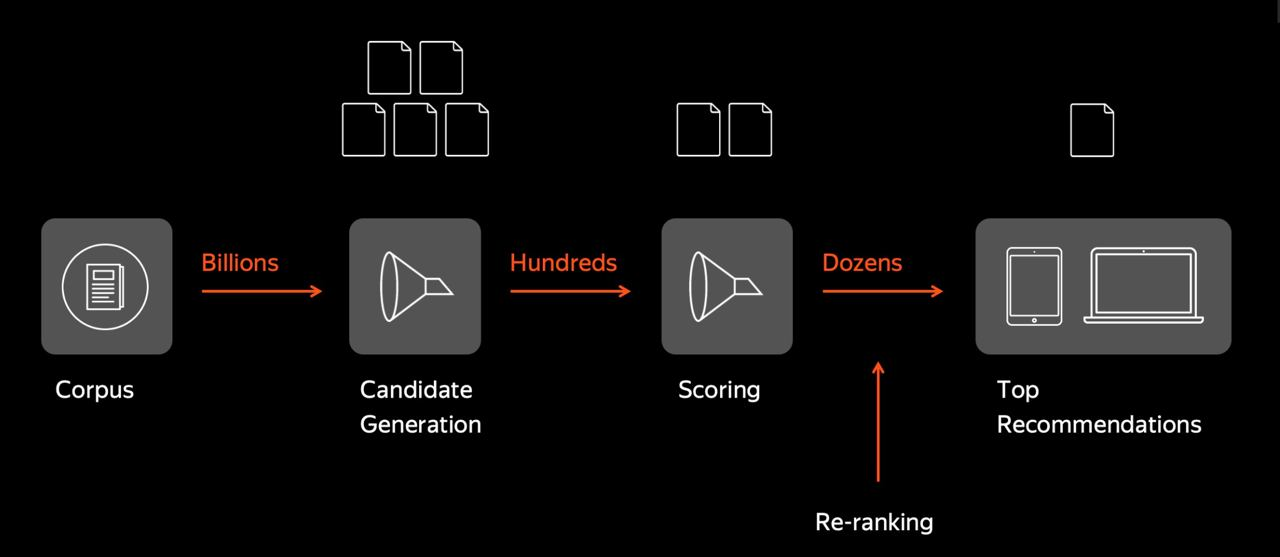

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: list[list[int]], predicted: list[list[int]], k: int = 20) -> float:
    total_ap = 0.0
    N = len(relevant)
    
    for rel, pred in zip(relevant, predicted):
        ap = 0.0
        relevant_count = 0
        sum_precision = 0.0
        
        pred_k = pred[:k]
        
        for i, track in enumerate(pred_k, 1):
            if track in rel:
                relevant_count += 1
                precision_at_i = relevant_count / i
                sum_precision += precision_at_i
        
        if relevant_count > 0:
            ap = sum_precision / min(len(rel), k)
        
        total_ap += ap
    
    return total_ap / N

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame, seed=322):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.seed = seed
        self._set_seed()
        
    def _set_seed(self):
        np.random.seed(self.seed)
    
    def recommend(self, uid: int):
        self._set_seed()
        scores = np.random.rand(self.n_items)
        return np.argsort(scores)[::-1]
    
    def remove_train_items(self, preds: List[List[int]], k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = [self.recommend(id) for id in range(self.n_users)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]



### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    ratings_binary = (ratings > 0).astype(int)
    user_vector = (user_vector > 0).astype(int)
    
    intersection = ratings_binary @ user_vector.T
    union = ratings_binary.sum(axis=1) + user_vector.sum() - intersection
    
    similarity = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=(union != 0))
    
    return similarity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [24]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vec = self.R[uid]
        
        sims = self.similarity(user_vec)
        
        neighbors_mask = (sims > self.alpha) & (np.arange(self.n_users) != uid)
        neighbors = np.where(neighbors_mask)[0]
        
        if len(neighbors) == 0:
            return super().recommend(uid)
        
        neighbor_ratings = self.R[neighbors]
        
        scores = (neighbor_ratings.T * sims[neighbors]).sum(axis=1)
        
        sum_sims = np.sum(sims[neighbors])
        if sum_sims > 0:
            scores /= sum_sims
        
        recommended_items = np.argsort(scores)[::-1]
        
        return recommended_items

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

  0%|          | 0/5 [00:00<?, ?it/s]

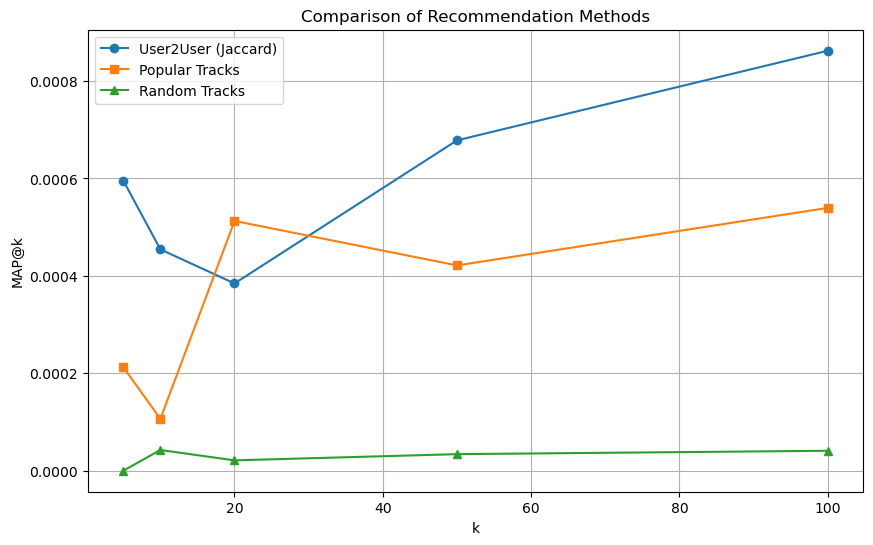

Лучший метод: User2User (Jaccard)


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

user2user = User2User(train_ratings)
popular_tracks = train_ratings['trackId'].value_counts().index.values
random_tracks = np.random.permutation(train_ratings['trackId'].unique())

k_values = [5, 10, 20, 50, 100]
mapk_user2user = []
mapk_popular = []
mapk_random = []

for k in tqdm(k_values):
    user2user_preds = []
    for uid in test_users:
        recs = user2user.recommend(uid)[:k]
        user2user_preds.append(recs)
    mapk_user2user.append(mapk(test_relevant, user2user_preds, k))
    
    popular_preds = [popular_tracks[:k] for _ in test_users]
    mapk_popular.append(mapk(test_relevant, popular_preds, k))
    
    random_preds = [np.random.choice(random_tracks, size=k, replace=False) for _ in test_users]
    mapk_random.append(mapk(test_relevant, random_preds, k))

plt.figure(figsize=(10, 6))
plt.plot(k_values, mapk_user2user, label='User2User (Jaccard)', marker='o')
plt.plot(k_values, mapk_popular, label='Popular Tracks', marker='s')
plt.plot(k_values, mapk_random, label='Random Tracks', marker='^')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Comparison of Recommendation Methods')
plt.legend()
plt.grid(True)
plt.show()

best_method = np.argmax([np.mean(mapk_user2user), np.mean(mapk_popular), np.mean(mapk_random)])
methods = ['User2User (Jaccard)', 'Popular Tracks', 'Random Tracks']
print(f'Лучший метод: {methods[best_method]}')

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [48]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [25]:
model = User2User(train_ratings)
user_id = np.random.randint(0, model.n_users)

In [26]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
6,Meet Me Halfway,['Black Eyed Peas']
7,I Gotta Feeling,['Black Eyed Peas']
27,La Camisa Negra,['Juanes']
282,Glamorous,"['Fergie', 'Ludacris']"
290,My Humps,['Black Eyed Peas']
302,Analogue (All I Want),['a-ha']
354,Dancing Queen,['ABBA']
410,November Rain,"[""Guns N' Roses""]"
411,Don't Cry,"[""Guns N' Roses""]"
507,Be Yourself,['Audioslave']


In [27]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
1056,Don't Speak,['No Doubt']
805,Zombie,['The Cranberries']
8263,Shape Of My Heart,['Sting']
9438,Что такое осень,['ДДТ']
33436,Believer,['Imagine Dragons']
2814,Numb,['Linkin Park']
6376,"You're Gonna Go Far, Kid",['The Offspring']
9694,We Will Rock You,['Queen']
42172,На Титанике,['Лолита']
7780,ИСКАЛА,['Земфира']


In [28]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
59817,Пошлю его на...,['Дора']
60511,How You Like That,['BLACKPINK']
60666,Там ревели горы,['Miyagi & Andy Panda']
60834,Jerk,['Oliver Tree']
60941,All Of Me,"['The Score', 'Travis Barker']"
61379,Midnight Sky,['Miley Cyrus']
61626,Every Time We Touch,"['Lauren Babic', 'Cole Rolland']"
61786,When You Find Me,['plenka']
61808,Somebody Told Me,['Motionless In White']
61850,Девочка-пришелец,['ЛСП']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Градиент по $ p_u $:

$\frac{\partial L}{\partial p_u} = 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u$

Градиент по $ q_i $:

$\frac{\partial L}{\partial q_i} = 2(\langle p_u, q_i \rangle - r_{ui})p_u + 2\lambda q_i$

Далее просто делаем спуск по обоим переменным


**ALS:**

Тут мы фиксируем один из векторов и считаем что у нас просто MSE для регрессии, тогда:

$-\frac{\partial L}{\partial p_u} = 2 \sum_{i \in I_u} (r_{ui} - \langle p_u, q_i \rangle) q_i + 2\lambda p_u = 0$

Решаем относительно $p_u$:

$\sum_{i \in I_u} q_i q_i^T p_u + \lambda p_u = \sum_{i \in I_u} r_{ui} q_i$

$\left(\sum_{i \in I_u} q_i q_i^T + \lambda I\right) p_u = \sum_{i \in I_u} r_{ui} q_i$

$p_u = \left(\sum_{i \in I_u} q_i q_i^T + \lambda I\right)^{-1} \sum_{i \in I_u} r_{ui} q_i$

Точно так же будет и для айтемов:

$\frac{\partial L}{\partial q_i} = 2 \sum_{u \in U_i} (\langle p_u, q_i \rangle - r_{ui}) p_u + 2\lambda q_i = 0$

Отсюда:

$q_i = \left(\sum_{u \in U_i} p_u p_u^T + \lambda I\right)^{-1} \sum_{u \in U_i} r_{ui} p_u$


**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [49]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(scale=1./dim, size=(self.n_users, dim))
        self.Q = np.random.normal(scale=1./dim, size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                self._sgd_step()
            elif self.mode == 'als':
                self._als_step()

    def _sgd_step(self):
        for (u, i) in zip(self.ratings['userId'], self.ratings['trackId']):
            pred = np.dot(self.P[u], self.Q[i])
            error = 1 - pred
            
            grad_p = error * self.Q[i] - self.lamb * self.P[u]
            grad_q = error * self.P[u] - self.lamb * self.Q[i]
            
            self.P[u] += self.lr * grad_p
            self.Q[i] += self.lr * grad_q

    def _als_step(self):
        for u in range(self.n_users):
            items = self.ratings[self.ratings['userId'] == u]['trackId']
            if len(items) == 0:
                continue
                
            Q_u = self.Q[items]
            A = Q_u.T @ Q_u + self.lamb * np.eye(self.dim)
            b = Q_u.sum(axis=0)
            
            self.P[u] = np.linalg.solve(A, b)
        
        for i in range(self.n_items):
            users = self.ratings[self.ratings['trackId'] == i]['userId']
            if len(users) == 0:
                continue
                
            P_i = self.P[users]
            A = P_i.T @ P_i + self.lamb * np.eye(self.dim)
            b = P_i.sum(axis=0)
            
            self.Q[i] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

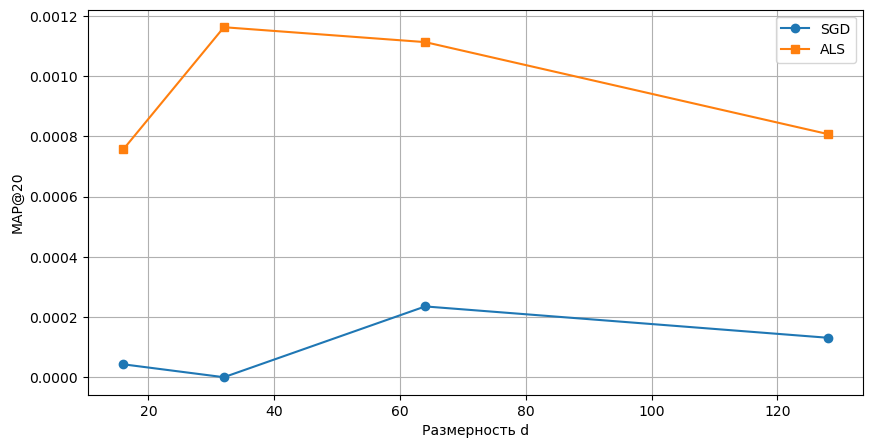

In [51]:
dims = [16, 32, 64, 128]
k = 20
map_sgd = []
map_als = []

for d in dims:
    # SGD
    model_sgd = LatentFactorModel(train_ratings, dim=d, mode='sgd')
    model_sgd.fit(num_iters=10)
    preds_sgd = model_sgd.get_test_recommendations(k)
    map_sgd.append(mapk(test_relevant, preds_sgd, k))
    
    # ALS
    model_als = LatentFactorModel(train_ratings, dim=d, mode='als')
    model_als.fit(num_iters=10)
    preds_als = model_als.get_test_recommendations(k)
    map_als.append(mapk(test_relevant, preds_als, k))

plt.figure(figsize=(10, 5))
plt.plot(dims, map_sgd, label='SGD', marker='o')
plt.plot(dims, map_als, label='ALS', marker='s')
plt.xlabel('Размерность d')
plt.ylabel('MAP@20')
plt.legend()
plt.grid()
plt.show()

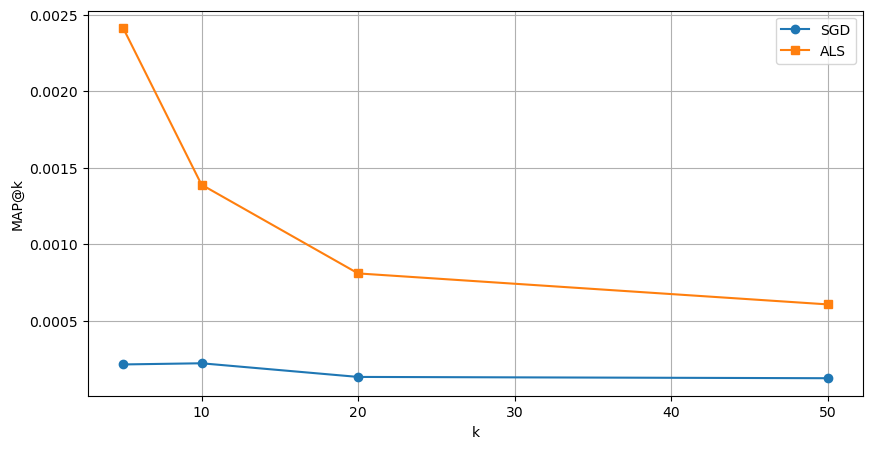

In [52]:
k_values = [5, 10, 20, 50]
d = 64
map_sgd_k = []
map_als_k = []

for k in k_values:
    # SGD
    preds_sgd = model_sgd.get_test_recommendations(k)
    map_sgd_k.append(mapk(test_relevant, preds_sgd, k))
    
    # ALS
    preds_als = model_als.get_test_recommendations(k)
    map_als_k.append(mapk(test_relevant, preds_als, k))

plt.figure(figsize=(10, 5))
plt.plot(k_values, map_sgd_k, label='SGD', marker='o')
plt.plot(k_values, map_als_k, label='ALS', marker='s')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

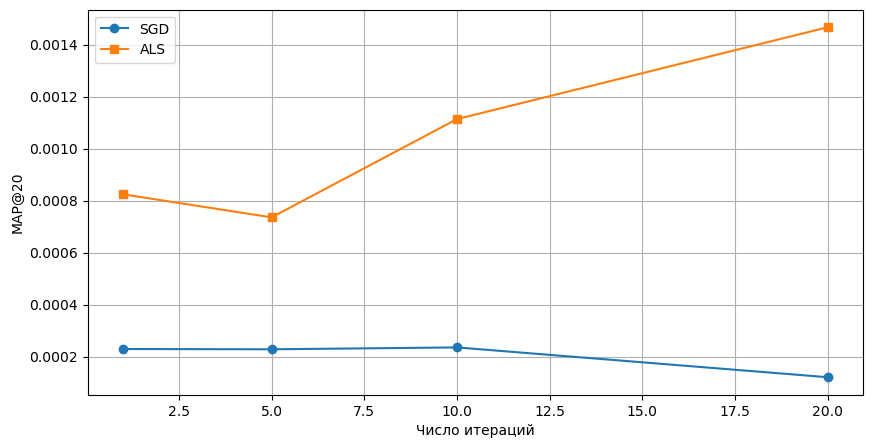

In [53]:
iters = [1, 5, 10, 20]
map_sgd_iters = []
map_als_iters = []

for n in iters:
    # SGD
    model_sgd = LatentFactorModel(train_ratings, dim=64, mode='sgd')
    model_sgd.fit(num_iters=n)
    preds_sgd = model_sgd.get_test_recommendations(20)
    map_sgd_iters.append(mapk(test_relevant, preds_sgd, 20))
    
    # ALS
    model_als = LatentFactorModel(train_ratings, dim=64, mode='als')
    model_als.fit(num_iters=n)
    preds_als = model_als.get_test_recommendations(20)
    map_als_iters.append(mapk(test_relevant, preds_als, 20))

plt.figure(figsize=(10, 5))
plt.plot(iters, map_sgd_iters, label='SGD', marker='o')
plt.plot(iters, map_als_iters, label='ALS', marker='s')
plt.xlabel('Число итераций')
plt.ylabel('MAP@20')
plt.legend()
plt.grid()
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [55]:
model = LatentFactorModel(train_ratings, dim=35, mode='als')
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [56]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
65250,Aether,['Geoxor'],0.644610
44687,5 минут,['Rauf & Faik'],0.611199
1436,My Beloved Monster,['Eels'],0.608618
4342,Burn To Shine,['Ben Harper & The Innocent Criminals'],0.602566
10380,Monte Gargano,['Truckfighters'],0.592341
38004,Ты ещё со мной здесь,"['Thomas Mraz', 'Yanix']",0.588620
57824,Как пережить расставание,Unknown Artist,0.574891
30204,I Wanna Be Loved by You,['Marilyn Monroe'],0.574056
26589,In The Dark,['3 Doors Down'],0.573031


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [60]:
sgd_model = LatentFactorModel(train_ratings, mode='sgd', dim= 35)
sgd_model.fit(748)
als_predicted = sgd_model.get_test_recommendations(100)

user_model = User2User(train_ratings)
user_predicted = user_model.get_test_recommendations(100)

  0%|          | 0/748 [00:00<?, ?it/s]

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [62]:
good_users = user_model.n_users
good_items = user_model.n_items
id_index = {user_id: index for index, user_id in enumerate(test_users)}

In [67]:
import scipy
from sklearn import model_selection

df = pd.DataFrame(columns=['userId', 'trackId', 'cosine', 'mean_jaccard', 'track_popularity', 'listened_tracks', 'target'])
average_jaccard = {user_id: user_model.similarity(user_model.R[user_id]).mean() for user_id in range(good_users)}
track_popularity_scores = {track_id: user_model.R[:, track_id].mean() for track_id in range(good_items)}
tracks_listened = {user_id: user_model.R[user_id].sum() for user_id in range(good_users)}

for user_idx, predicted_tracks in tqdm(list(enumerate(user_predicted))):
    for track_idx in predicted_tracks:
        cosine_similarity = scipy.spatial.distance.cosine(sgd_model.P[user_idx], sgd_model.Q[track_idx])
        target_value = int(track_idx in test_relevant[id_index[user_idx]]) if user_idx in id_index else 0
        df.loc[len(df)] = [user_idx, track_idx, cosine_similarity, average_jaccard[user_idx],
                           track_popularity_scores[track_idx], tracks_listened[user_idx], target_value]

for user_idx, predicted_tracks in tqdm(list(enumerate(als_predicted))):
    for track_idx in predicted_tracks:
        cosine_similarity = scipy.spatial.distance.cosine(sgd_model.P[user_idx], sgd_model.Q[track_idx])
        target_value = int(track_idx in test_relevant[id_index[user_idx]]) if user_idx in id_index else 0
        df.loc[len(df)] = [user_idx, track_idx, cosine_similarity, average_jaccard[user_idx],
                           track_popularity_scores[track_idx], tracks_listened[user_idx], target_value]
        
df['trackId'] = df['trackId'].astype(int)
df['userId'] = df['userId'].astype(int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop(columns=['target']), df['target'], test_size=0.4, stratify=df['target'])



  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [68]:
import catboost

# group_id == user_id here
X_train.sort_values(by='userId', inplace=True)
X_test.sort_values(by='userId', inplace=True)

train_pool = catboost.Pool(X_train, y_train, group_id=X_train['userId'])
test_pool = catboost.Pool(X_test, y_test, group_id=X_test['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [69]:
catboost_classifier = catboost.CatBoostClassifier(silent=True, auto_class_weights='Balanced', eval_metric='MAP:top=20')
catboost_classifier.fit(train_pool, eval_set=test_pool)
catboost_classifier.best_score_

{'learn': {'Logloss': 0.004448390969724583, 'MAP:top=20': 0.2425531914893617},
 'validation': {'Logloss': 0.6943992098807417,
  'MAP:top=20': 0.01648451803267033}}

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [71]:
from catboost import CatBoostRanker

catboost_ranker = CatBoostRanker(silent=True, eval_metric='MAP:top=20')
catboost_ranker.fit(train_pool, eval_set=test_pool)
catboost_ranker.best_score_

{'learn': {'MAP:top=20': 0.2425531914893617},
 'validation': {'PFound': 0.018439211350817573,
  'MAP:top=20': 0.008595466555416492}}